In [1]:
import gzip
import numpy as np

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, BatchNormalization
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.utils import to_categorical

**Load Data**

In [3]:
train_imgs = gzip.open('train-images-idx3-ubyte.gz','r') 
train_label = gzip.open('train-labels-idx1-ubyte.gz','r') 

test_imgs = gzip.open('t10k-images-idx3-ubyte.gz' ,'r') 
test_label = gzip.open('t10k-labels-idx1-ubyte.gz' ,'r') 

In [4]:
image_size = 28
train_images = 60000
test_images = 10000

train_imgs.read(16)
buf_train = train_imgs.read(image_size * image_size * train_images)
X_train = np.frombuffer(buf_train, dtype=np.uint8).astype(np.float32)
X_train = X_train.reshape( train_images, image_size, image_size, 1)

test_imgs.read(16)
buf_test = test_imgs.read(image_size * image_size * test_images)
X_test = np.frombuffer(buf_test, dtype=np.uint8).astype(np.float32)
X_test = X_test.reshape( test_images, image_size, image_size, 1)

In [5]:
X_train = X_train/255
X_test = X_test/255

In [6]:
train_label.read(8)
y_train1 = []
for i in range(0,60000):   
    buf_train_label = train_label.read(1)
    labels = np.frombuffer(buf_train_label, dtype=np.uint8).astype(np.int64)
    y_train1.append(labels)
    
test_label.read(8)
y_test1 = []
for i in range(0,10000):   
    buf_test_label = test_label.read(1)
    labels = np.frombuffer(buf_test_label, dtype=np.uint8).astype(np.int64)
    y_test1.append(labels)
    
y_train1 = np.array(y_train1)
y_test1 = np.array(y_test1)

In [7]:
y_train = to_categorical(y_train1)
y_test = to_categorical(y_test1)

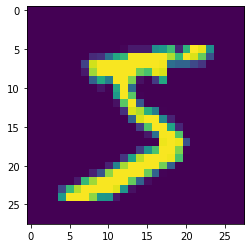

In [8]:
import matplotlib.pyplot as plt
image = np.asarray(X_train[0]).squeeze()
plt.imshow(image)
plt.show()

**CNN Model with gridsearch for hyperparameter tuning**

In [9]:
def define_model(neurons=64,conv_filter=32,learn_rate=0.01,optimizer='Adam'):
  model = Sequential()
  model.add(Conv2D(conv_filter,(3, 3),activation='relu',kernel_initializer='he_uniform',input_shape=(28, 28, 1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
 
  model.add(Flatten()) 
  model.add(Dense(neurons, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  loss_fn='categorical_crossentropy'
  if optimizer=='Adam':
    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
  else:
    opt = SGD(lr=learn_rate)
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
  return model

In [10]:
# create model
model = KerasClassifier(build_fn=define_model, verbose=0)

# define the grid search parameters
batch_size = [64, 112]
epochs = [30, 40]
optimizer = ['SGD', 'Adam'] 
learn_rate = [0.001, 0.01]
neurons= [64,128]
conv_filter = [32,64]

param_grid = dict(batch_size=batch_size, epochs=epochs,learn_rate=learn_rate,neurons=neurons,optimizer=optimizer,conv_filter=conv_filter)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train,y_train, validation_split=0.1, verbose=1)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/40
844/844 [==============================] - 8s 7ms/step - loss: 0.3395 - accuracy: 0.9043 - val_loss: 0.0739 - val_accuracy: 0.9810
Epoch 2/40
844/844 [==============================] - 5s 6ms/step - loss: 0.0601 - accuracy: 0.9821 - val_loss: 0.0539 - val_accuracy: 0.9865
Epoch 3/40
844/844 [==============================] - 5s 7ms/step - loss: 0.0353 - accuracy: 0.9904 - val_loss: 0.0494 - val_accuracy: 0.9870
Epoch 4/40
844/844 [==============================] - 5s 7ms/step - loss: 0.0250 - accuracy: 0.9942 - val_loss: 0.0502 - val_accuracy: 0.9860
Epoch 5/40
844/844 [==============================] - 5s 6ms/step - loss: 0.0166 - accuracy: 0.9965 - val_loss: 0.0476 - val_accuracy: 0.9877
Epoch 6/40
844/844 [==============================] - 5s 7ms/step - loss: 0.0118 - accuracy: 0.9980 - val_loss: 0.0453 - val_accuracy: 0.9870
Epoch 7/40
844/844 [==============================] - 5s 6ms/step - loss: 0.0090 - accuracy: 0.9987 - val_loss: 0.0462 - val_accuracy: 0.9878
Epoch 

**CNN Model with Data Augmentation at best parameter from gridsearch**

In [11]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
844/844 [==============================] - 23s 27ms/step - loss: 1.5117 - accuracy: 0.4937 - val_loss: 0.7983 - val_accuracy: 0.7412
Epoch 2/40
844/844 [==============================] - 23s 27ms/step - loss: 0.7526 - accuracy: 0.7573 - val_loss: 0.5878 - val_accuracy: 0.8158
Epoch 3/40
844/844 [==============================] - 23s 27ms/step - loss: 0.5909 - accuracy: 0.8076 - val_loss: 0.5353 - val_accuracy: 0.8265
Epoch 4/40
844/844 [==============================] - 22s 26ms/step - loss: 0.5159 - accuracy: 0.8318 - val_loss: 0.4711 - val_accuracy: 0.8547
Epoch 5/40
844/844 [==============================] - 23s 27ms/step - loss: 0.4700 - accuracy: 0.8463 - val_loss: 0.4772 - val_accuracy: 0.8478
Epoch 6/40
844/844 [==============================] - 22s 27ms/step - loss: 0.4353 - accuracy: 0.8597 - val_loss: 0.3995 - val_accuracy: 0.8767
Epoch 7/40
844/844 [==============================] - 22s 26ms/step - loss: 0.4116 - accuracy: 0.8678 - val_loss: 0.3880 - val_accuracy:

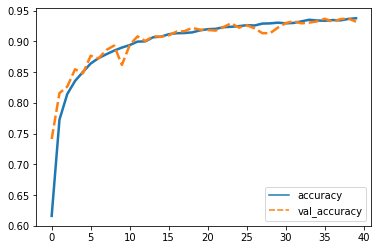

In [17]:
# optimize parameters of the fit method 
cnn_model = define_model(neurons = grid_result.best_params_['neurons'],
                          learn_rate = grid_result.best_params_['learn_rate'],
                          optimizer = grid_result.best_params_['optimizer'],
                          conv_filter = grid_result.best_params_['conv_filter'])

# With data augmentation 
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.1) 

datagen.fit(X_train)

history = cnn_model.fit_generator(datagen.flow(X_train,y_train, batch_size=grid_result.best_params_['batch_size'], subset='training'),
                                  epochs = grid_result.best_params_['epochs'], 
                                  validation_data =datagen.flow(X_train, y_train, batch_size=grid_result.best_params_['batch_size'], subset='validation'),
                                  verbose = 1)                        

# plot accuracy on training and validation data
df_history = pd.DataFrame(history.history)
sns.lineplot(data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);

In [18]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix

In [23]:
# predict classes for test set
yhat = cnn_model.predict(X_test) 

In [41]:

ypred = np.argmax(yhat,axis=1)
ytest = np.argmax(y_test,axis=1)

accuracy = accuracy_score(ytest, ypred)
print('Accuracy: %f' % accuracy)

precision = precision_score(ytest, ypred,pos_label='positive',average='micro')
print('Precision: %f' % precision)

recall = recall_score(ytest, ypred, pos_label='positive',average='micro')
print('Recall: %f' % recall)

f1 = f1_score(ytest, ypred, pos_label='positive',average='micro')
print('F1 score: %f' % f1)

conf_matrix = confusion_matrix(ytest, ypred)
print('Confusion Matrix: \n')
print(conf_matrix)

Accuracy: 0.928400
Precision: 0.928400
Recall: 0.928400
F1 score: 0.928400
Confusion Matrix: 

[[ 942    0    4    8    2    4    3    2    3   12]
 [   1 1083    4    5    6    0    1   33    2    0]
 [   0    5  889   33   14   58    6   19    7    1]
 [   0    2    0  999    0    8    0    1    0    0]
 [   0    0    4    0  951    0    1   11    4   11]
 [   0    1    7  120    0  754    3    6    0    1]
 [   4    4   29   10    5   27  876    1    2    0]
 [   0    1   32   33    4   13    0  934    4    7]
 [   0    0    6   38    3    8    0    2  909    8]
 [   0    0    2   28   10    7    0    8    7  947]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
